Inter-Annotator Agreement Analysis
Comparing Human vs LLM Role Annotations
This notebook calculates inter-annotator agreement between human and LLM annotations for the 'role' column.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', None)

# === ADJUST THESE PATHS ===
HUMAN_PATH = '../result/human/optimized_annotations_SHORT_human.csv'
LLM_PATH = '../result/flattened-by-expression/short/optimized_annotations_SHORT.csv'

# Load human annotations
human_df = pd.read_csv(HUMAN_PATH)
print(f"Human annotations: {human_df.shape[0]} rows, {human_df.shape[1]} columns")

# Load LLM annotations
llm_df = pd.read_csv(LLM_PATH)
print(f"LLM annotations: {llm_df.shape[0]} rows, {llm_df.shape[1]} columns")

Human annotations: 50 rows, 13 columns
LLM annotations: 50 rows, 29 columns


In [5]:
# Human annotation columns
print("Human annotation columns:")
print(list(human_df.columns))
print("_"*50)
# LLM annotation columns
print("LLM annotation columns:")
print(list(llm_df.columns))

Human annotation columns:
['thesis_code', 'section', 'sentence', 'expression_number', 'expression', 'is_reflexive', 'scope_classification', 'L1_classification', 'L2_classification', 'L3_classification', 'L3_borderline', 'L1_borderline_is', 'L2_borderline_is']
__________________________________________________
LLM annotation columns:
['thesis_code', 'section', 'sentence', 'expression_number', 'expression', 'is_reflexive', 'reflexivity_type', 'reflexivity_reasoning', 'scope_classification', 'scope_reach', 'scope_reasoning', 'L1_classification', 'L1_reasoning', 'L2_classification', 'L2_reasoning', 'L3_classification', 'L3_borderline', 'L3_reasoning', 'L1_borderline_is', 'L1_borderline_dominant', 'L1_borderline_secondary', 'L1_borderline_why', 'L2_borderline_is', 'L2_borderline_primary', 'L2_borderline_secondary', 'L2_borderline_tertiary', 'L2_borderline_strength', 'L2_borderline_why', 'comprehensive_justification']


## Compare and Align Columns (CREATING UID)
We keep only columns that exist in the human annotations (our reference).

In [6]:
# Find column differences
human_cols = set(human_df.columns)
llm_cols = set(llm_df.columns)

common_cols = human_cols & llm_cols
only_in_human = human_cols - llm_cols
only_in_llm = llm_cols - human_cols

print(f"Common columns: {len(common_cols)}")
print(f"Only in human: {len(only_in_human)}")
print(f"Only in LLM: {len(only_in_llm)}")

Common columns: 13
Only in human: 0
Only in LLM: 16


In [8]:
# Columns only in LLM (will be dropped)
if only_in_llm:
    print("Columns in LLM but NOT in Human (will be dropped):")
    for col in sorted(only_in_llm):
        print(f"  - {col}")
else:
    print("No extra columns in LLM")
print("_"*50)
# Columns only in human (missing from LLM)
if only_in_human:
    print("Columns in Human but NOT in LLM (missing):")
    for col in sorted(only_in_human):
        print(f"  - {col}")
else:
    print("No missing columns in Human code")

Columns in LLM but NOT in Human (will be dropped):
  - L1_borderline_dominant
  - L1_borderline_secondary
  - L1_borderline_why
  - L1_reasoning
  - L2_borderline_primary
  - L2_borderline_secondary
  - L2_borderline_strength
  - L2_borderline_tertiary
  - L2_borderline_why
  - L2_reasoning
  - L3_reasoning
  - comprehensive_justification
  - reflexivity_reasoning
  - reflexivity_type
  - scope_reach
  - scope_reasoning
__________________________________________________
No missing columns in Human code


In [9]:
# Keep only human columns (in same order)
cols_to_keep = [col for col in human_df.columns if col in llm_cols]

human_aligned = human_df[cols_to_keep].copy()
llm_aligned = llm_df[cols_to_keep].copy()

print(f"Aligned human: {human_aligned.shape}")
print(f"Aligned LLM: {llm_aligned.shape}")
print(f"\nColumns kept: {cols_to_keep}")

Aligned human: (50, 13)
Aligned LLM: (50, 13)

Columns kept: ['thesis_code', 'section', 'sentence', 'expression_number', 'expression', 'is_reflexive', 'scope_classification', 'L1_classification', 'L2_classification', 'L3_classification', 'L3_borderline', 'L1_borderline_is', 'L2_borderline_is']


In [10]:
# Examine key columns in both datasets

# --- is_reflexive ---
print("IS_REFLEXIVE Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['is_reflexive'].value_counts())
print("\nLLM:")
print(llm_aligned['is_reflexive'].value_counts())

# --- scope_classification ---
print("\n" + "=" * 40)
print("SCOPE_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['scope_classification'].value_counts())
print("\nLLM:")
print(llm_aligned['scope_classification'].value_counts())

# --- L1_classification ---
print("\n" + "=" * 40)
print("L1_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['L1_classification'].value_counts())
print("\nLLM:")
print(llm_aligned['L1_classification'].value_counts())

# --- L2_classification ---
print("\n" + "=" * 40)
print("L2_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['L2_classification'].value_counts(dropna=False))
print("\nLLM:")
print(llm_aligned['L2_classification'].value_counts(dropna=False))

# --- L3_classification ---
print("\n" + "=" * 40)
print("L3_CLASSIFICATION Distribution:")
print("-" * 40)
print("Human:")
print(human_aligned['L3_classification'].value_counts(dropna=False))
print("\nLLM:")
print(llm_aligned['L3_classification'].value_counts(dropna=False))

IS_REFLEXIVE Distribution:
----------------------------------------
Human:
is_reflexive
True     25
False    25
Name: count, dtype: int64

LLM:
is_reflexive
False    28
True     22
Name: count, dtype: int64

SCOPE_CLASSIFICATION Distribution:
----------------------------------------
Human:
scope_classification
MICRO    27
MESO     13
MACRO    10
Name: count, dtype: int64

LLM:
scope_classification
MICRO    28
MESO     11
MACRO    11
Name: count, dtype: int64

L1_CLASSIFICATION Distribution:
----------------------------------------
Human:
L1_classification
MD      45
PROP     5
Name: count, dtype: int64

LLM:
L1_classification
MD      47
PROP     3
Name: count, dtype: int64

L2_CLASSIFICATION Distribution:
----------------------------------------
Human:
L2_classification
INT_ACTIVE      37
INT_ACTIONAL     8
NaN              5
Name: count, dtype: int64

LLM:
L2_classification
INT_ACTIVE      39
INT_ACTIONAL     8
NaN              3
Name: count, dtype: int64

L3_CLASSIFICATION Distributi

In [24]:
# Align datasets - this assumes both datasets have some common identifier

def align_annotations(human_df, llm_df, id_column=None):
    """
    Align human and LLM annotations based on a common identifier.
    If no id_column is specified, assumes same order and length.
    """
    if human_df is None or llm_df is None:
        return None, None

    if id_column and id_column in human_df.columns and id_column in llm_df.columns:
        # Merge on common identifier
        merged = pd.merge(human_df, llm_df, on=id_column, suffixes=('_human', '_llm'))
        return merged['role_human'], merged['role_llm']
    else:
        # Assume same order and length
        min_len = min(len(human_df), len(llm_df))
        return human_df['role'][:min_len], llm_df['role'][:min_len]

# Aligning the data based on sentence (adjust id_column as needed)

human_roles, llm_roles = align_annotations(human_df, llm_df, id_column=None)

if human_roles is not None and llm_roles is not None:
    print(f"Aligned dataset size: {len(human_roles)}")
    print(f"Sample alignment check:")
    comparison_df = pd.DataFrame({
        'Human': human_roles.head(10),
        'LLM': llm_roles.head(10)
    })
    print(comparison_df)
else:
    print("Could not align the datasets. Please check data loading and column names.")

KeyError: 'role'

In [13]:
# Columns to use for unique ID
id_cols = ['thesis_code', 'section', 'sentence', 'expression_number']

# Create UID
human_aligned['uid'] = human_aligned[id_cols].astype(str).agg('|'.join, axis=1)
llm_aligned['uid'] = llm_aligned[id_cols].astype(str).agg('|'.join, axis=1)

print("Sample UIDs:")
print(human_aligned['uid'].head())

Sample UIDs:
0    AP1|Introduction|Below, Figure 1.1 visualises ...
1    AP1|Introduction|Below, Figure 1.1 visualises ...
2    AP1|Introduction|Below, Figure 1.1 visualises ...
3    AP1|Introduction|Finally, the structure of the...
4    AP1|Introduction|Finally, the structure of the...
Name: uid, dtype: object


In [14]:
# Check for duplicates
human_dups = human_aligned['uid'].duplicated().sum()
llm_dups = llm_aligned['uid'].duplicated().sum()

print(f"Duplicate UIDs in human: {human_dups}")
print(f"Duplicate UIDs in LLM: {llm_dups}")

Duplicate UIDs in human: 0
Duplicate UIDs in LLM: 0


In [15]:
human_uids = set(human_aligned['uid'])
llm_uids = set(llm_aligned['uid'])

common_items = human_uids & llm_uids
only_human = human_uids - llm_uids
only_llm = llm_uids - human_uids

print(f"Items in human: {len(human_uids)}")
print(f"Items in LLM: {len(llm_uids)}")
print(f"Common items: {len(common_items)}")
print(f"Only in human: {len(only_human)}")
print(f"Only in LLM: {len(only_llm)}")

Items in human: 50
Items in LLM: 50
Common items: 50
Only in human: 0
Only in LLM: 0


In [16]:
# Merge on UID
merged = pd.merge(
    human_aligned,
    llm_aligned,
    on='uid',
    suffixes=('_human', '_llm'),
    how='inner'
)

print(f"Merged dataset: {merged.shape[0]} rows, {merged.shape[1]} columns")

Merged dataset: 50 rows, 27 columns


In [17]:
# Preview merged data
merged.head()

,thesis_code_human,section_human,sentence_human,expression_number_human,expression_human,is_reflexive_human,scope_classification_human,L1_classification_human,L2_classification_human,L3_classification_human,L3_borderline_human,L1_borderline_is_human,L2_borderline_is_human,uid,thesis_code_llm,section_llm,sentence_llm,expression_number_llm,expression_llm,is_reflexive_llm,scope_classification_llm,L1_classification_llm,L2_classification_llm,L3_classification_llm,L3_borderline_llm,L1_borderline_is_llm,L2_borderline_is_llm
0,AP1,Introduction,"Below, Figure 1.1 visualises this:",1,Below,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False,"AP1|Introduction|Below, Figure 1.1 visualises ...",AP1,Introduction,"Below, Figure 1.1 visualises this:",1,Below,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False
1,AP1,Introduction,"Below, Figure 1.1 visualises this:",2,Figure 1.1,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False,"AP1|Introduction|Below, Figure 1.1 visualises ...",AP1,Introduction,"Below, Figure 1.1 visualises this:",2,Figure 1.1,True,MICRO,MD,INT_ACTIVE,Endophoric Marker,False,False,False
2,AP1,Introduction,"Below, Figure 1.1 visualises this:",3,this,True,MESO,MD,INT_ACTIVE,Endophoric Marker,False,False,False,"AP1|Introduction|Below, Figure 1.1 visualises ...",AP1,Introduction,"Below, Figure 1.1 visualises this:",3,this,True,MESO,MD,INT_ACTIVE,Endophoric Marker,False,False,False
3,AP1,Introduction,"Finally, the structure of the overall thesis w...",1,Finally,True,MESO,MD,INT_ACTIVE,Frame Marker,False,False,False,"AP1|Introduction|Finally, the structure of the...",AP1,Introduction,"Finally, the structure of the overall thesis w...",1,Finally,True,MESO,MD,INT_ACTIVE,Frame Marker,False,False,False
4,AP1,Introduction,"Finally, the structure of the overall thesis w...",2,the structure of the overall thesis will be ex...,True,MACRO,MD,INT_ACTIVE,Frame Marker,False,False,False,"AP1|Introduction|Finally, the structure of the...",AP1,Introduction,"Finally, the structure of the overall thesis w...",2,the structure of the overall thesis will be ex...,True,MACRO,MD,INT_ACTIVE,Frame Marker,False,False,False


In [19]:
# Find columns that have both _human and _llm versions
comparison_cols = []
for col in merged.columns:
    if col.endswith('_human'):
        base = col.replace('_human', '')
        if f"{base}_llm" in merged.columns:
            comparison_cols.append(base)

print("Columns available for IAA comparison:")
for col in comparison_cols:
    print(f"  - {col}")

Columns available for IAA comparison:
  - thesis_code
  - section
  - sentence
  - expression_number
  - expression
  - is_reflexive
  - scope_classification
  - L1_classification
  - L2_classification
  - L3_classification
  - L3_borderline
  - L1_borderline_is
  - L2_borderline_is


In [20]:
print("="*50)
print("SUMMARY")
print("="*50)
print(f"Human annotations: {len(human_df)} items")
print(f"LLM annotations: {len(llm_df)} items")
print(f"Matched for comparison: {len(merged)} items")
print(f"\nVariables for IAA:")
for col in comparison_cols:
    if col not in ['thesis_code', 'section', 'sentence', 'expression_number', 'expression']:
        print(f"  • {col}")

SUMMARY
Human annotations: 50 items
LLM annotations: 50 items
Matched for comparison: 50 items

Variables for IAA:
  • is_reflexive
  • scope_classification
  • L1_classification
  • L2_classification
  • L3_classification
  • L3_borderline
  • L1_borderline_is
  • L2_borderline_is


### It's time to calculate IAA, F1 score, and Confusion Matrix

## 1. Confusion Matrix + F1 Score

In [25]:

# ============================================
# IS_REFLEXIVE: Confusion Matrix + F1 Score
# ============================================

print("=" * 60)
print("IS_REFLEXIVE: Full Analysis")
print("=" * 60)

human_col = merged['is_reflexive_human'].astype(str)
llm_col = merged['is_reflexive_llm'].astype(str)

# --- Basic Agreement ---
agree = (human_col == llm_col).sum()
total = len(merged)
pct = agree / total * 100

print(f"\nAgreement: {agree}/{total} = {pct:.1f}%")

# --- Cohen's Kappa ---
kappa = cohen_kappa_score(human_col, llm_col)
print(f"Cohen's κ: {kappa:.3f}")

# --- Confusion Matrix ---
print("\n" + "-" * 40)
print("CONFUSION MATRIX")
print("-" * 40)
print("                  Human=False  Human=True")
cm = confusion_matrix(human_col, llm_col, labels=['False', 'True'])
print(f"LLM=False            {cm[0,0]:<8}     {cm[0,1]}")
print(f"LLM=True             {cm[1,0]:<8}     {cm[1,1]}")

# Extract values
TN = cm[0,0]  # Both say False
FP = cm[0,1]  # LLM=False, Human=True (LLM missed it)
FN = cm[1,0]  # LLM=True, Human=False (LLM overclaimed)
TP = cm[1,1]  # Both say True

print(f"\nTP={TP}, TN={TN}, FP={FP}, FN={FN}")

# --- F1, Precision, Recall for "True" (Reflexive) ---
print("\n" + "-" * 40)
print("REFLEXIVE DETECTION (True as positive class)")
print("-" * 40)

human_binary = (human_col == 'True').astype(int)
llm_binary = (llm_col == 'True').astype(int)

precision = precision_score(human_binary, llm_binary)
recall = recall_score(human_binary, llm_binary)
f1 = f1_score(human_binary, llm_binary)

print(f"Precision: {precision:.3f}  (of LLM's 'True', {precision*100:.1f}% were correct)")
print(f"Recall:    {recall:.3f}  (of actual 'True', LLM found {recall*100:.1f}%)")
print(f"F1 Score:  {f1:.3f}")

# --- PABAK ---
pabak = 2 * pct/100 - 1
print(f"\nPABAK:     {pabak:.3f}")

# --- Disagreements ---
print("\n" + "-" * 40)
print("DISAGREEMENTS")
print("-" * 40)
disagree = merged[human_col != llm_col]
if len(disagree) > 0:
    for _, row in disagree.iterrows():
        print(f"  '{row['expression_human']}': Human={row['is_reflexive_human']}, LLM={row['is_reflexive_llm']}")
else:
    print("  None")


IS_REFLEXIVE: Full Analysis

Agreement: 47/50 = 94.0%
Cohen's κ: 0.880

----------------------------------------
CONFUSION MATRIX
----------------------------------------
                  Human=False  Human=True
LLM=False            25           0
LLM=True             3            22

TP=22, TN=25, FP=0, FN=3

----------------------------------------
REFLEXIVE DETECTION (True as positive class)
----------------------------------------
Precision: 1.000  (of LLM's 'True', 100.0% were correct)
Recall:    0.880  (of actual 'True', LLM found 88.0%)
F1 Score:  0.936

PABAK:     0.880

----------------------------------------
DISAGREEMENTS
----------------------------------------
  'Further': Human=True, LLM=False
  'Ultimately': Human=True, LLM=False
  'Eventually': Human=True, LLM=False


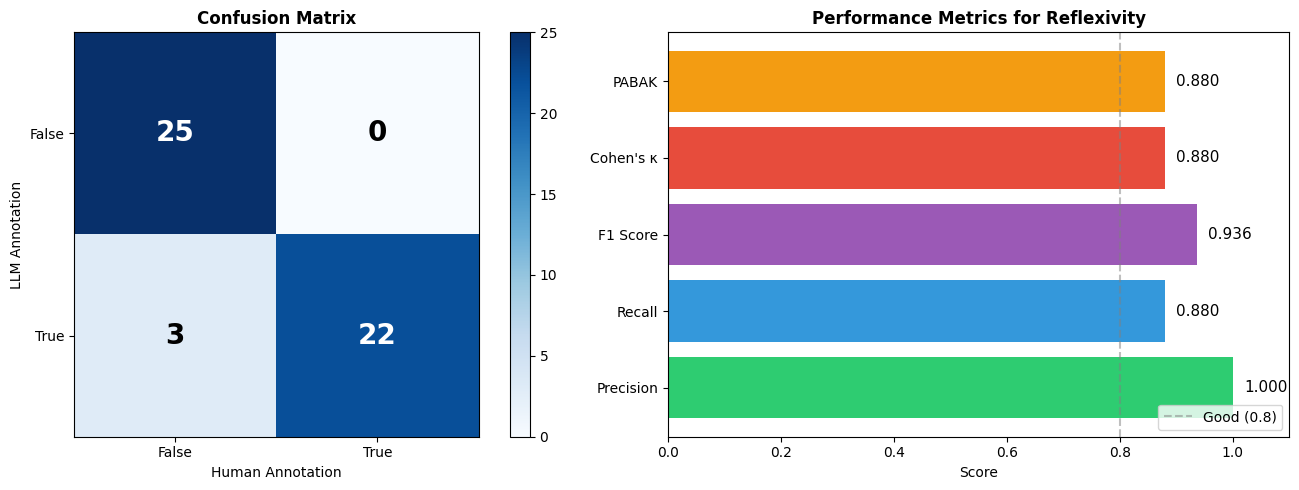


✓ Figure saved as: is_reflexive_iaa_analysis.png


In [26]:
# ============================================
# ALTERNATIVE: More detailed visualization
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Confusion Matrix ---
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax1.figure.colorbar(im, ax=ax1)

ax1.set(xticks=[0, 1],
        yticks=[0, 1],
        xticklabels=['False', 'True'],
        yticklabels=['False', 'True'],
        xlabel='Human Annotation',
        ylabel='LLM Annotation')
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax1.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20, fontweight='bold')

# --- Right: Metrics Bar Chart ---
ax2 = axes[1]
metrics = ['Precision', 'Recall', 'F1 Score', "Cohen's κ", 'PABAK']
values = [precision, recall, f1, kappa, pabak]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

bars = ax2.barh(metrics, values, color=colors)
ax2.set_xlim(0, 1.1)
ax2.set_xlabel('Score')
ax2.set_title('Performance Metrics for Reflexivity', fontsize=12, fontweight='bold')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=11)

# Add reference line at 0.8 (good threshold)
ax2.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('is_reflexive_iaa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: is_reflexive_iaa_analysis.png")

### 2. SCOPE_CLASSIFICATION: Confusion Matrix + Metrics

In [27]:
# ============================================
# SCOPE_CLASSIFICATION: Confusion Matrix + Metrics
# ============================================
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report

print("=" * 60)
print("SCOPE_CLASSIFICATION: Full Analysis")
print("=" * 60)

human_col = merged['scope_classification_human']
llm_col = merged['scope_classification_llm']

# --- Basic Agreement ---
agree = (human_col == llm_col).sum()
total = len(merged)
pct = agree / total * 100

print(f"\nAgreement: {agree}/{total} = {pct:.1f}%")

# --- Cohen's Kappa (unweighted) ---
kappa = cohen_kappa_score(human_col, llm_col)
print(f"Cohen's κ (unweighted): {kappa:.3f}")

# --- Cohen's Kappa (weighted - for ordinal data) ---
scope_map = {'MICRO': 0, 'MESO': 1, 'MACRO': 2}
human_num = human_col.map(scope_map)
llm_num = llm_col.map(scope_map)
kappa_weighted = cohen_kappa_score(human_num, llm_num, weights='linear')
print(f"Cohen's κ (weighted):   {kappa_weighted:.3f}")

# --- Confusion Matrix ---
print("\n" + "-" * 40)
print("CONFUSION MATRIX")
print("-" * 40)
labels = ['MICRO', 'MESO', 'MACRO']
cm = confusion_matrix(human_col, llm_col, labels=labels)

print("                Human=MICRO  Human=MESO  Human=MACRO")
print(f"LLM=MICRO          {cm[0,0]:<8}    {cm[0,1]:<8}    {cm[0,2]}")
print(f"LLM=MESO           {cm[1,0]:<8}    {cm[1,1]:<8}    {cm[1,2]}")
print(f"LLM=MACRO          {cm[2,0]:<8}    {cm[2,1]:<8}    {cm[2,2]}")

# --- Per-class metrics ---
print("\n" + "-" * 40)
print("PER-CLASS METRICS (Precision, Recall, F1)")
print("-" * 40)
print(classification_report(human_col, llm_col, labels=labels, digits=3))

# --- PABAK ---
pabak = 2 * pct/100 - 1
print(f"PABAK: {pabak:.3f}")

# --- Disagreements ---
print("\n" + "-" * 40)
print("DISAGREEMENTS")
print("-" * 40)
disagree = merged[human_col != llm_col]
if len(disagree) > 0:
    for _, row in disagree.iterrows():
        print(f"  '{row['expression_human']}': Human={row['scope_classification_human']}, LLM={row['scope_classification_llm']}")
else:
    print("  None")

SCOPE_CLASSIFICATION: Full Analysis

Agreement: 48/50 = 96.0%
Cohen's κ (unweighted): 0.933
Cohen's κ (weighted):   0.952

----------------------------------------
CONFUSION MATRIX
----------------------------------------
                Human=MICRO  Human=MESO  Human=MACRO
LLM=MICRO          27          0           0
LLM=MESO           1           11          1
LLM=MACRO          0           0           10

----------------------------------------
PER-CLASS METRICS (Precision, Recall, F1)
----------------------------------------
              precision    recall  f1-score   support

       MICRO      0.964     1.000     0.982        27
        MESO      1.000     0.846     0.917        13
       MACRO      0.909     1.000     0.952        10

    accuracy                          0.960        50
   macro avg      0.958     0.949     0.950        50
weighted avg      0.963     0.960     0.959        50

PABAK: 0.920

----------------------------------------
DISAGREEMENTS
--------------

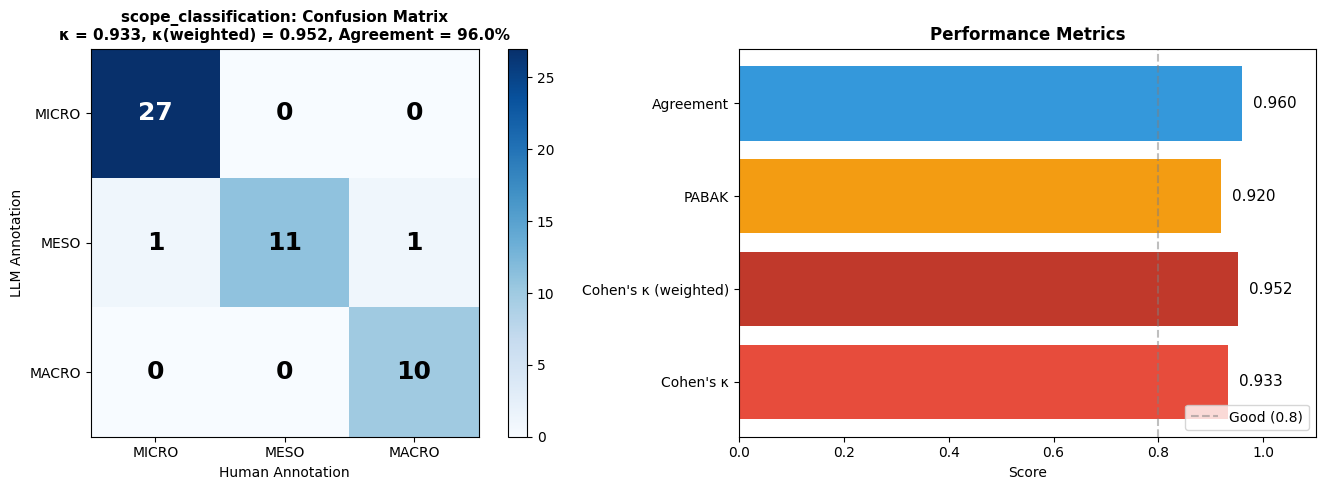


✓ Figure saved as: scope_classification_iaa_analysis.png


In [28]:
# ============================================
# VISUALIZE SCOPE CONFUSION MATRIX
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Confusion Matrix ---
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax1.figure.colorbar(im, ax=ax1)

labels = ['MICRO', 'MESO', 'MACRO']
ax1.set(xticks=[0, 1, 2],
        yticks=[0, 1, 2],
        xticklabels=labels,
        yticklabels=labels,
        xlabel='Human Annotation',
        ylabel='LLM Annotation')
ax1.set_title(f'scope_classification: Confusion Matrix\nκ = {kappa:.3f}, κ(weighted) = {kappa_weighted:.3f}, Agreement = {pct:.1f}%',
              fontsize=11, fontweight='bold')

thresh = cm.max() / 2
for i in range(3):
    for j in range(3):
        ax1.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=18, fontweight='bold')

# --- Right: Metrics Bar Chart ---
ax2 = axes[1]
metrics = ["Cohen's κ", "Cohen's κ (weighted)", 'PABAK', 'Agreement']
values = [kappa, kappa_weighted, pabak, pct/100]
colors = ['#e74c3c', '#c0392b', '#f39c12', '#3498db']

bars = ax2.barh(metrics, values, color=colors)
ax2.set_xlim(0, 1.1)
ax2.set_xlabel('Score')
ax2.set_title('Performance Metrics', fontsize=12, fontweight='bold')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=11)

# Add reference line at 0.8
ax2.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('scope_classification_iaa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: scope_classification_iaa_analysis.png")

In [31]:
# ============================================
# L1_CLASSIFICATION: Confusion Matrix + Metrics (3 categories)
# ============================================
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report

print("=" * 60)
print("L1_CLASSIFICATION: Full Analysis")
print("=" * 60)

human_col = merged['L1_classification_human']
llm_col = merged['L1_classification_llm']

# --- Check unique values ---
print("\nUnique values:")
print(f"Human: {human_col.unique()}")
print(f"LLM:   {llm_col.unique()}")

# --- Basic Agreement ---
agree = (human_col == llm_col).sum()
total = len(merged)
pct = agree / total * 100

print(f"\nAgreement: {agree}/{total} = {pct:.1f}%")

# --- Marginal Distributions ---
print("\n" + "-" * 40)
print("MARGINAL DISTRIBUTIONS")
print("-" * 40)

labels = ['MD', 'PROP', 'borderline']  # Adjust if your labels are different

for label in labels:
    human_count = (human_col == label).sum()
    llm_count = (llm_col == label).sum()
    print(f"{label:<12} Human: {human_count:>3} ({human_count/total*100:>5.1f}%)   LLM: {llm_count:>3} ({llm_count/total*100:>5.1f}%)")

# --- Cohen's Kappa ---
kappa = cohen_kappa_score(human_col, llm_col)
print(f"\nCohen's κ: {kappa:.3f}")

# --- PABAK ---
pabak = 2 * pct/100 - 1
print(f"PABAK:     {pabak:.3f}")

# --- Confusion Matrix ---
print("\n" + "-" * 40)
print("CONFUSION MATRIX")
print("-" * 40)

cm = confusion_matrix(human_col, llm_col, labels=labels)

print(f"                Human={labels[0]:<10} Human={labels[1]:<10} Human={labels[2]:<10}")
for i, label in enumerate(labels):
    print(f"LLM={label:<12}    {cm[i,0]:<12}    {cm[i,1]:<12}    {cm[i,2]:<12}")

# --- Per-class Metrics ---
print("\n" + "-" * 40)
print("PER-CLASS METRICS (Precision, Recall, F1)")
print("-" * 40)
print(classification_report(human_col, llm_col, labels=labels, digits=3, zero_division=0))

# --- Disagreements ---
print("\n" + "-" * 40)
print("DISAGREEMENTS")
print("-" * 40)
disagree = merged[human_col != llm_col]
if len(disagree) > 0:
    for _, row in disagree.iterrows():
        print(f"  '{row['expression_human']}': Human={row['L1_classification_human']}, LLM={row['L1_classification_llm']}")
else:
    print("  None")

L1_CLASSIFICATION: Full Analysis

Unique values:
Human: ['MD' 'PROP']
LLM:   ['MD' 'PROP']

Agreement: 48/50 = 96.0%

----------------------------------------
MARGINAL DISTRIBUTIONS
----------------------------------------
MD           Human:  45 ( 90.0%)   LLM:  47 ( 94.0%)
PROP         Human:   5 ( 10.0%)   LLM:   3 (  6.0%)
borderline   Human:   0 (  0.0%)   LLM:   0 (  0.0%)

Cohen's κ: 0.730
PABAK:     0.920

----------------------------------------
CONFUSION MATRIX
----------------------------------------
                Human=MD         Human=PROP       Human=borderline
LLM=MD              45              0               0           
LLM=PROP            2               3               0           
LLM=borderline      0               0               0           

----------------------------------------
PER-CLASS METRICS (Precision, Recall, F1)
----------------------------------------
              precision    recall  f1-score   support

          MD      0.957     1.000     0.9

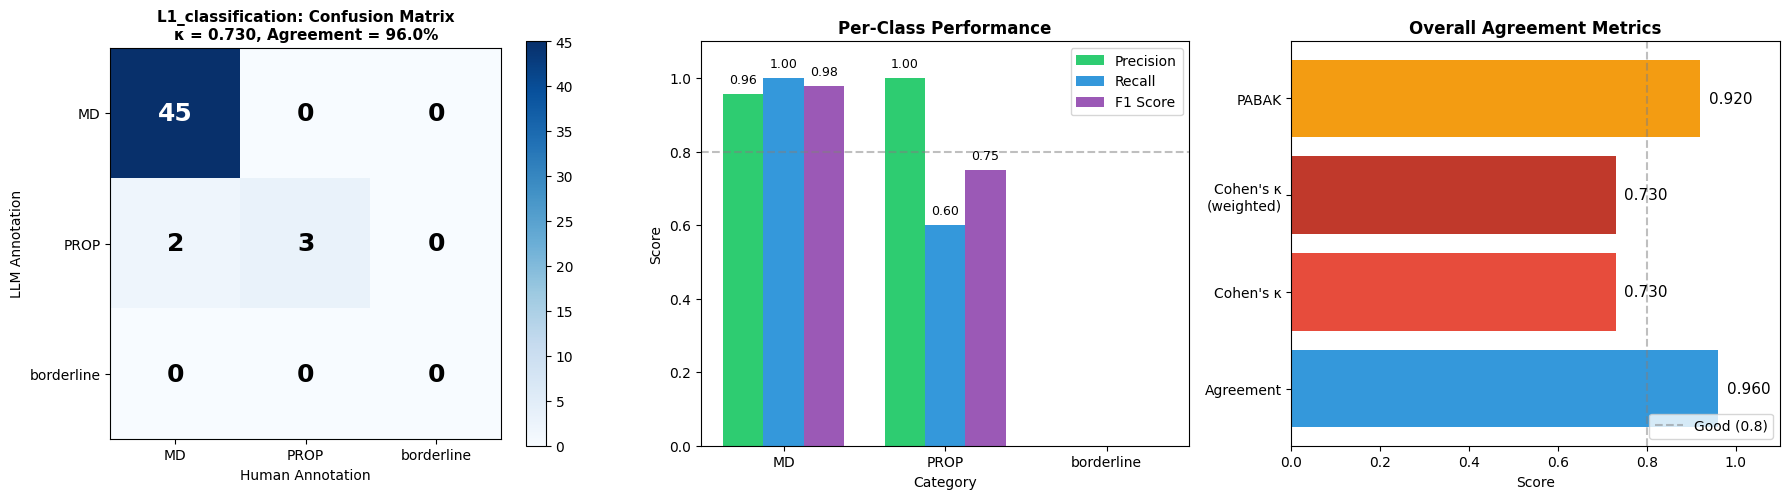


✓ Figure saved as: L1_classification_3cat_iaa_analysis.png


In [36]:
# ============================================
# VISUALIZE L1 CONFUSION MATRIX (3x3) + All Metrics
# ============================================
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# --- Calculate weighted kappa (for ordinal interpretation) ---
# Map categories to ordinal scale: MD=0, borderline=1, PROP=2
ordinal_map = {'MD': 0, 'borderline': 1, 'PROP': 2}
human_ordinal = human_col.map(ordinal_map)
llm_ordinal = llm_col.map(ordinal_map)
kappa_weighted = cohen_kappa_score(human_ordinal, llm_ordinal, weights='linear')

# --- Create figure with 3 subplots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ============================================
# Left: Confusion Matrix
# ============================================
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax1.figure.colorbar(im, ax=ax1)

ax1.set(xticks=[0, 1, 2],
        yticks=[0, 1, 2],
        xticklabels=labels,
        yticklabels=labels,
        xlabel='Human Annotation',
        ylabel='LLM Annotation')
ax1.set_title(f'L1_classification: Confusion Matrix\nκ = {kappa:.3f}, Agreement = {pct:.1f}%',
              fontsize=11, fontweight='bold')

thresh = cm.max() / 2
for i in range(3):
    for j in range(3):
        ax1.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=18, fontweight='bold')

# ============================================
# Middle: Per-class F1 scores
# ============================================
ax2 = axes[1]

f1_per_class = []
prec_per_class = []
rec_per_class = []

for label in labels:
    human_binary = (human_col == label).astype(int)
    llm_binary = (llm_col == label).astype(int)
    f1_per_class.append(f1_score(human_binary, llm_binary, zero_division=0))
    prec_per_class.append(precision_score(human_binary, llm_binary, zero_division=0))
    rec_per_class.append(recall_score(human_binary, llm_binary, zero_division=0))

x = np.arange(len(labels))
width = 0.25

bars1 = ax2.bar(x - width, prec_per_class, width, label='Precision', color='#2ecc71')
bars2 = ax2.bar(x, rec_per_class, width, label='Recall', color='#3498db')
bars3 = ax2.bar(x + width, f1_per_class, width, label='F1 Score', color='#9b59b6')

ax2.set_xlabel('Category')
ax2.set_ylabel('Score')
ax2.set_title('Per-Class Performance', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# ============================================
# Right: Overall Metrics (Agreement, Kappa, Weighted Kappa, PABAK)
# ============================================
ax3 = axes[2]

metrics = ['Agreement', "Cohen's κ", "Cohen's κ\n(weighted)", 'PABAK']
values = [pct/100, kappa, kappa_weighted, pabak]
colors = ['#3498db', '#e74c3c', '#c0392b', '#f39c12']

bars = ax3.barh(metrics, values, color=colors)
ax3.set_xlim(0, 1.1)
ax3.set_xlabel('Score')
ax3.set_title('Overall Agreement Metrics', fontsize=12, fontweight='bold')

# Add value labels
for bar, val in zip(bars, values):
    ax3.text(val + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=11)

# Add reference line at 0.8
ax3.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')
ax3.legend(loc='lower right')

plt.tight_layout()
plt.savefig('L1_classification_3cat_iaa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: L1_classification_3cat_iaa_analysis.png")

In [37]:
# ============================================
# PRINT ALL METRICS SUMMARY
# ============================================
print("=" * 60)
print("L1_CLASSIFICATION: ALL METRICS SUMMARY")
print("=" * 60)

print(f"\n--- Overall Metrics ---")
print(f"Agreement:              {pct:.1f}%")
print(f"Cohen's κ:              {kappa:.3f}")
print(f"Cohen's κ (weighted):   {kappa_weighted:.3f}")
print(f"PABAK:                  {pabak:.3f}")

print(f"\n--- Per-Class Metrics ---")
print(f"{'Category':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 48)
for i, label in enumerate(labels):
    print(f"{label:<12} {prec_per_class[i]:<12.3f} {rec_per_class[i]:<12.3f} {f1_per_class[i]:<12.3f}")

print(f"\n--- Macro Averages ---")
print(f"Macro Precision: {np.mean(prec_per_class):.3f}")
print(f"Macro Recall:    {np.mean(rec_per_class):.3f}")
print(f"Macro F1:        {np.mean(f1_per_class):.3f}")

L1_CLASSIFICATION: ALL METRICS SUMMARY

--- Overall Metrics ---
Agreement:              96.0%
Cohen's κ:              0.730
Cohen's κ (weighted):   0.730
PABAK:                  0.920

--- Per-Class Metrics ---
Category     Precision    Recall       F1          
------------------------------------------------
MD           0.957        1.000        0.978       
PROP         1.000        0.600        0.750       
borderline   0.000        0.000        0.000       

--- Macro Averages ---
Macro Precision: 0.652
Macro Recall:    0.533
Macro F1:        0.576


In [43]:
# ============================================
# L2_CLASSIFICATION: Full Analysis (including PROP/NaN)
# ============================================
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 60)
print("L2_CLASSIFICATION: Full Analysis")
print("=" * 60)

# --- Create a copy and replace NaN with 'PROP' ---
merged_l2 = merged.copy()
merged_l2['L2_classification_human'] = merged_l2['L2_classification_human'].fillna('PROP')
merged_l2['L2_classification_llm'] = merged_l2['L2_classification_llm'].fillna('PROP')

# Also replace empty strings with 'PROP'
merged_l2['L2_classification_human'] = merged_l2['L2_classification_human'].replace('', 'PROP')
merged_l2['L2_classification_llm'] = merged_l2['L2_classification_llm'].replace('', 'PROP')

human_col = merged_l2['L2_classification_human']
llm_col = merged_l2['L2_classification_llm']

# --- Check unique values ---
print("\nUnique values (after converting NaN to PROP):")
print(f"Human: {human_col.unique()}")
print(f"LLM:   {llm_col.unique()}")

# --- Basic Agreement ---
agree = (human_col == llm_col).sum()
total = len(merged_l2)
pct = agree / total * 100

print(f"\nAgreement: {agree}/{total} = {pct:.1f}%")

# --- Marginal Distributions ---
print("\n" + "-" * 40)
print("MARGINAL DISTRIBUTIONS")
print("-" * 40)

labels = ['INT_ACTIVE', 'INT_ACTIONAL', 'PROP']

for label in labels:
    human_count = (human_col == label).sum()
    llm_count = (llm_col == label).sum()
    print(f"{label:<15} Human: {human_count:>3} ({human_count/total*100:>5.1f}%)   LLM: {llm_count:>3} ({llm_count/total*100:>5.1f}%)")

# --- Cohen's Kappa ---
kappa = cohen_kappa_score(human_col, llm_col)
print(f"\nCohen's κ: {kappa:.3f}")

# --- Weighted Kappa (ordinal: INT_ACTIVE -> INT_ACTIONAL -> PROP) ---
ordinal_map = {'INT_ACTIVE': 0, 'INT_ACTIONAL': 1, 'PROP': 2}
human_ordinal = human_col.map(ordinal_map)
llm_ordinal = llm_col.map(ordinal_map)
kappa_weighted = cohen_kappa_score(human_ordinal, llm_ordinal, weights='linear')
print(f"Cohen's κ (weighted): {kappa_weighted:.3f}")

# --- PABAK ---
pabak = 2 * pct/100 - 1
print(f"PABAK: {pabak:.3f}")

# --- Confusion Matrix ---
print("\n" + "-" * 40)
print("CONFUSION MATRIX")
print("-" * 40)

cm = confusion_matrix(human_col, llm_col, labels=labels)

print(f"                   Human=INT_ACTIVE  Human=INT_ACTIONAL  Human=PROP")
print(f"LLM=INT_ACTIVE          {cm[0,0]:<12}       {cm[0,1]:<12}      {cm[0,2]}")
print(f"LLM=INT_ACTIONAL        {cm[1,0]:<12}       {cm[1,1]:<12}      {cm[1,2]}")
print(f"LLM=PROP                {cm[2,0]:<12}       {cm[2,1]:<12}      {cm[2,2]}")

# --- Per-class Metrics ---
print("\n" + "-" * 40)
print("PER-CLASS METRICS (Precision, Recall, F1)")
print("-" * 40)
print(classification_report(human_col, llm_col, labels=labels, digits=3, zero_division=0))

# --- Disagreements ---
print("\n" + "-" * 40)
print("DISAGREEMENTS")
print("-" * 40)
disagree = merged_l2[human_col != llm_col]
if len(disagree) > 0:
    for _, row in disagree.iterrows():
        print(f"  '{row['expression_human']}': Human={row['L2_classification_human']}, LLM={row['L2_classification_llm']}")
else:
    print("  None")

L2_CLASSIFICATION: Full Analysis

Unique values (after converting NaN to PROP):
Human: ['INT_ACTIVE' 'INT_ACTIONAL' 'PROP']
LLM:   ['INT_ACTIVE' 'INT_ACTIONAL' 'PROP']

Agreement: 48/50 = 96.0%

----------------------------------------
MARGINAL DISTRIBUTIONS
----------------------------------------
INT_ACTIVE      Human:  37 ( 74.0%)   LLM:  39 ( 78.0%)
INT_ACTIONAL    Human:   8 ( 16.0%)   LLM:   8 ( 16.0%)
PROP            Human:   5 ( 10.0%)   LLM:   3 (  6.0%)

Cohen's κ: 0.898
Cohen's κ (weighted): 0.844
PABAK: 0.920

----------------------------------------
CONFUSION MATRIX
----------------------------------------
                   Human=INT_ACTIVE  Human=INT_ACTIONAL  Human=PROP
LLM=INT_ACTIVE          37                 0                 0
LLM=INT_ACTIONAL        0                  8                 0
LLM=PROP                2                  0                 3

----------------------------------------
PER-CLASS METRICS (Precision, Recall, F1)
--------------------------------

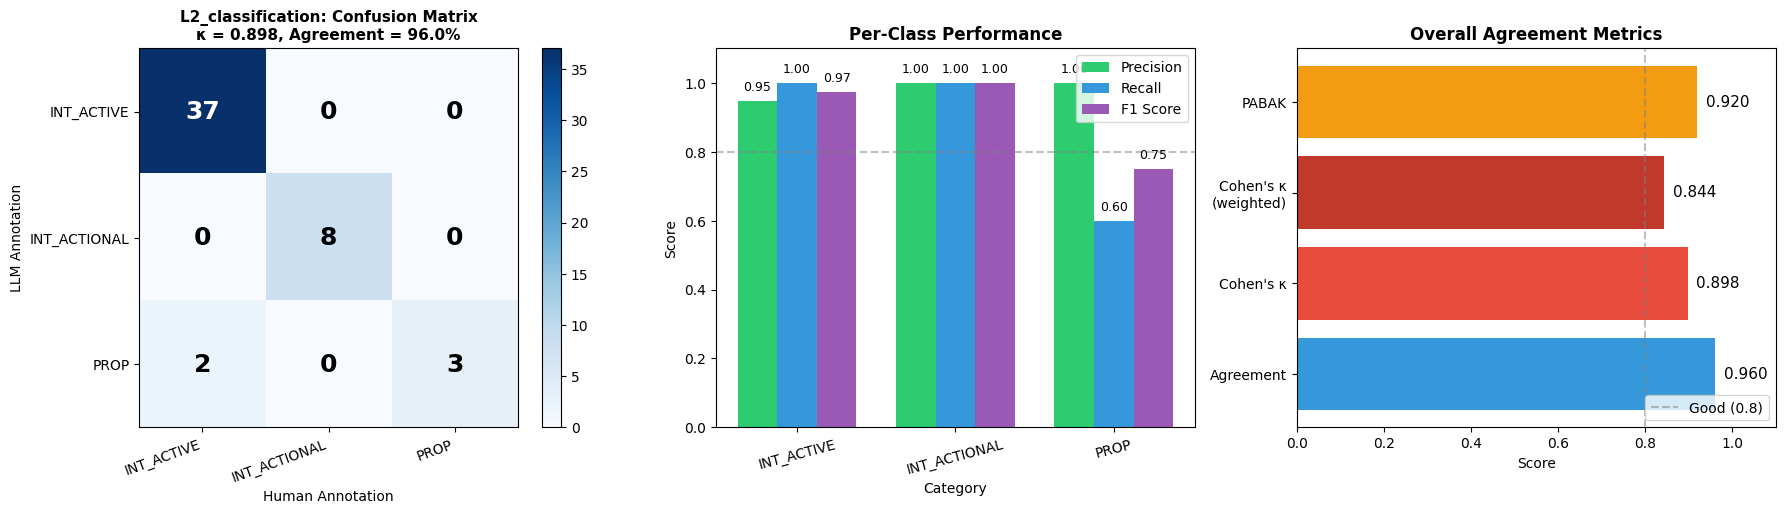


✓ Figure saved as: L2_classification_iaa_analysis.png


In [45]:
# ============================================
# VISUALIZE L2 CONFUSION MATRIX + All Metrics
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ============================================
# Left: Confusion Matrix (3x3)
# ============================================
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax1.figure.colorbar(im, ax=ax1)

ax1.set(xticks=[0, 1, 2],
        yticks=[0, 1, 2],
        xticklabels=labels,
        yticklabels=labels,
        xlabel='Human Annotation',
        ylabel='LLM Annotation')
ax1.set_title(f'L2_classification: Confusion Matrix\nκ = {kappa:.3f}, Agreement = {pct:.1f}%',
              fontsize=11, fontweight='bold')

# Rotate x labels for readability
plt.setp(ax1.get_xticklabels(), rotation=20, ha='right')

thresh = cm.max() / 2
for i in range(3):
    for j in range(3):
        ax1.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=18, fontweight='bold')

# ============================================
# Middle: Per-class F1 scores
# ============================================
ax2 = axes[1]

f1_per_class = []
prec_per_class = []
rec_per_class = []

for label in labels:
    human_binary = (human_col == label).astype(int)
    llm_binary = (llm_col == label).astype(int)
    f1_per_class.append(f1_score(human_binary, llm_binary, zero_division=0))
    prec_per_class.append(precision_score(human_binary, llm_binary, zero_division=0))
    rec_per_class.append(recall_score(human_binary, llm_binary, zero_division=0))

x = np.arange(len(labels))
width = 0.25

bars1 = ax2.bar(x - width, prec_per_class, width, label='Precision', color='#2ecc71')
bars2 = ax2.bar(x, rec_per_class, width, label='Recall', color='#3498db')
bars3 = ax2.bar(x + width, f1_per_class, width, label='F1 Score', color='#9b59b6')

ax2.set_xlabel('Category')
ax2.set_ylabel('Score')
ax2.set_title('Per-Class Performance', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=15)
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# ============================================
# Right: Overall Metrics
# ============================================
ax3 = axes[2]

metrics = ['Agreement', "Cohen's κ", "Cohen's κ\n(weighted)", 'PABAK']
values = [pct/100, kappa, kappa_weighted, pabak]
colors = ['#3498db', '#e74c3c', '#c0392b', '#f39c12']

bars = ax3.barh(metrics, values, color=colors)
ax3.set_xlim(0, 1.1)
ax3.set_xlabel('Score')
ax3.set_title('Overall Agreement Metrics', fontsize=12, fontweight='bold')

# Add value labels
for bar, val in zip(bars, values):
    ax3.text(val + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=11)

# Add reference line at 0.8
ax3.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')
ax3.legend(loc='lower right')

plt.tight_layout()
plt.savefig('L2_classification_iaa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: L2_classification_iaa_analysis.png")

In [46]:
# ============================================
# L3_CLASSIFICATION: Full Analysis
# ============================================
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 60)
print("L3_CLASSIFICATION: Full Analysis")
print("=" * 60)

# --- Create a copy and replace NaN/empty with 'PROP' ---
merged_l3 = merged.copy()
merged_l3['L3_classification_human'] = merged_l3['L3_classification_human'].fillna('PROP')
merged_l3['L3_classification_llm'] = merged_l3['L3_classification_llm'].fillna('PROP')
merged_l3['L3_classification_human'] = merged_l3['L3_classification_human'].replace('', 'PROP')
merged_l3['L3_classification_llm'] = merged_l3['L3_classification_llm'].replace('', 'PROP')

human_col = merged_l3['L3_classification_human']
llm_col = merged_l3['L3_classification_llm']

# --- Check unique values ---
print("\nUnique values (after converting NaN to PROP):")
print(f"Human: {sorted(human_col.unique())}")
print(f"LLM:   {sorted(llm_col.unique())}")

# --- Define full taxonomy ---
labels = [
    'Transition',
    'Frame Marker',
    'Endophoric Marker',
    'Evidential',
    'Code Gloss',
    'Hedge',
    'Booster',
    'Attitude Marker',
    'Self-Mention',
    'Engagement Marker',
    'PROP'
]

# --- Check which labels actually appear in the data ---
all_labels_in_data = set(human_col.unique()) | set(llm_col.unique())
print(f"\nLabels in data: {sorted(all_labels_in_data)}")

# Filter labels to only those present in data
labels_present = [l for l in labels if l in all_labels_in_data]
# Add any labels in data that aren't in our predefined list
extra_labels = [l for l in all_labels_in_data if l not in labels]
labels_present.extend(extra_labels)

print(f"Labels used for analysis: {labels_present}")

# --- Basic Agreement ---
agree = (human_col == llm_col).sum()
total = len(merged_l3)
pct = agree / total * 100

print(f"\nAgreement: {agree}/{total} = {pct:.1f}%")

# --- Marginal Distributions ---
print("\n" + "-" * 50)
print("MARGINAL DISTRIBUTIONS")
print("-" * 50)
print(f"{'Category':<25} {'Human':>8} {'%':>7} {'LLM':>8} {'%':>7}")
print("-" * 50)

for label in labels_present:
    human_count = (human_col == label).sum()
    llm_count = (llm_col == label).sum()
    if human_count > 0 or llm_count > 0:
        print(f"{label:<25} {human_count:>8} {human_count/total*100:>6.1f}% {llm_count:>8} {llm_count/total*100:>6.1f}%")

# --- Cohen's Kappa ---
kappa = cohen_kappa_score(human_col, llm_col)
print(f"\nCohen's κ: {kappa:.3f}")

# --- PABAK ---
pabak = 2 * pct/100 - 1
print(f"PABAK: {pabak:.3f}")

# --- Confusion Matrix ---
print("\n" + "-" * 50)
print("CONFUSION MATRIX")
print("-" * 50)

cm = confusion_matrix(human_col, llm_col, labels=labels_present)
print(f"\nMatrix shape: {cm.shape}")

# --- Per-class Metrics ---
print("\n" + "-" * 50)
print("PER-CLASS METRICS (Precision, Recall, F1)")
print("-" * 50)
print(classification_report(human_col, llm_col, labels=labels_present, digits=3, zero_division=0))

# --- Disagreements ---
print("\n" + "-" * 50)
print("DISAGREEMENTS")
print("-" * 50)
disagree = merged_l3[human_col != llm_col]
print(f"Total disagreements: {len(disagree)}")
if len(disagree) > 0:
    for _, row in disagree.iterrows():
        print(f"  '{row['expression_human']}': Human={row['L3_classification_human']}, LLM={row['L3_classification_llm']}")
else:
    print("  None")

L3_CLASSIFICATION: Full Analysis

Unique values (after converting NaN to PROP):
Human: ['Attitude Marker', 'Booster', 'Endophoric Marker', 'Engagement Marker', 'Evidential', 'Evidentials', 'Frame Marker', 'Frame Markers', 'Hedge', 'PROP', 'Transition']
LLM:   ['Attitude Marker', 'Booster', 'Endophoric Marker', 'Engagement Marker', 'Evidential', 'Evidentials', 'Frame Marker', 'Frame Markers', 'Hedge', 'PROP', 'Transition']

Labels in data: ['Attitude Marker', 'Booster', 'Endophoric Marker', 'Engagement Marker', 'Evidential', 'Evidentials', 'Frame Marker', 'Frame Markers', 'Hedge', 'PROP', 'Transition']
Labels used for analysis: ['Transition', 'Frame Marker', 'Endophoric Marker', 'Evidential', 'Hedge', 'Booster', 'Attitude Marker', 'Engagement Marker', 'PROP', 'Evidentials', 'Frame Markers']

Agreement: 48/50 = 96.0%

--------------------------------------------------
MARGINAL DISTRIBUTIONS
--------------------------------------------------
Category                     Human       %     

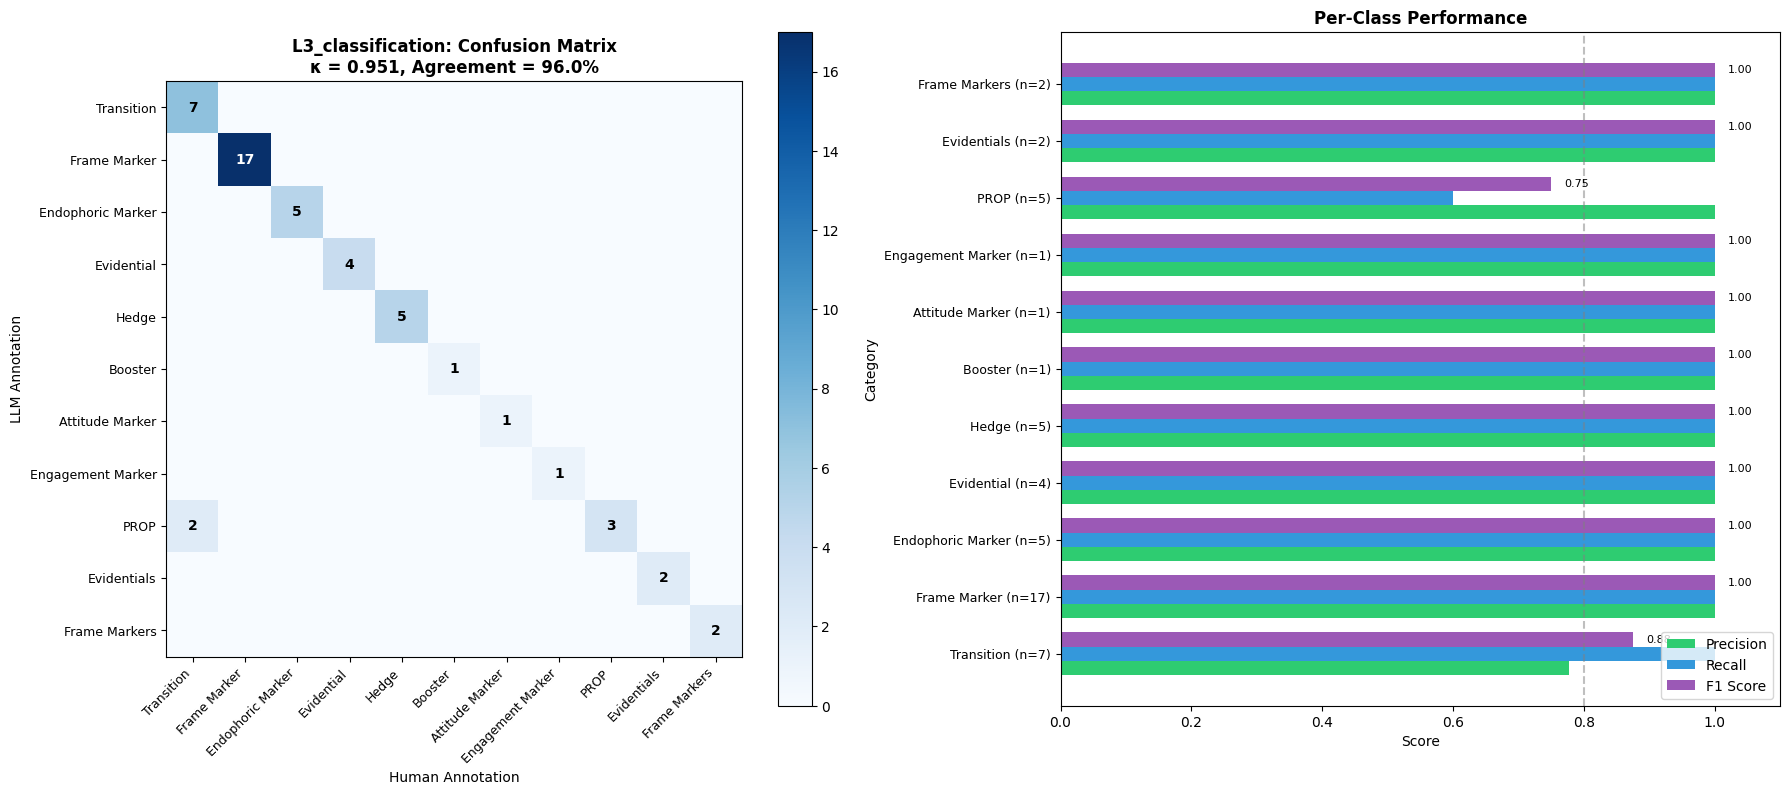


✓ Figure saved as: L3_classification_iaa_analysis.png


In [47]:
# ============================================
# VISUALIZE L3 CONFUSION MATRIX
# ============================================

# Create larger figure for many categories
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ============================================
# Left: Confusion Matrix (heatmap)
# ============================================
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax1.figure.colorbar(im, ax=ax1)

ax1.set(xticks=np.arange(len(labels_present)),
        yticks=np.arange(len(labels_present)),
        xticklabels=labels_present,
        yticklabels=labels_present,
        xlabel='Human Annotation',
        ylabel='LLM Annotation')
ax1.set_title(f'L3_classification: Confusion Matrix\nκ = {kappa:.3f}, Agreement = {pct:.1f}%',
              fontsize=12, fontweight='bold')

# Rotate x labels for readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax1.get_yticklabels(), fontsize=9)

# Add text annotations
thresh = cm.max() / 2
for i in range(len(labels_present)):
    for j in range(len(labels_present)):
        if cm[i, j] > 0:  # Only show non-zero values
            ax1.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=10, fontweight='bold')

# ============================================
# Right: Per-class F1 scores (horizontal bar)
# ============================================
ax2 = axes[1]

f1_per_class = []
prec_per_class = []
rec_per_class = []
support_per_class = []

for label in labels_present:
    human_binary = (human_col == label).astype(int)
    llm_binary = (llm_col == label).astype(int)
    f1_per_class.append(f1_score(human_binary, llm_binary, zero_division=0))
    prec_per_class.append(precision_score(human_binary, llm_binary, zero_division=0))
    rec_per_class.append(recall_score(human_binary, llm_binary, zero_division=0))
    support_per_class.append(human_binary.sum())

# Create horizontal bar chart
y = np.arange(len(labels_present))
height = 0.25

bars1 = ax2.barh(y - height, prec_per_class, height, label='Precision', color='#2ecc71')
bars2 = ax2.barh(y, rec_per_class, height, label='Recall', color='#3498db')
bars3 = ax2.barh(y + height, f1_per_class, height, label='F1 Score', color='#9b59b6')

ax2.set_xlabel('Score')
ax2.set_ylabel('Category')
ax2.set_title('Per-Class Performance', fontsize=12, fontweight='bold')
ax2.set_yticks(y)
ax2.set_yticklabels([f"{l} (n={s})" for l, s in zip(labels_present, support_per_class)], fontsize=9)
ax2.set_xlim(0, 1.1)
ax2.legend(loc='lower right')
ax2.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')

# Add value labels
for bars in [bars3]:  # Only show F1 labels to avoid clutter
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            ax2.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('L3_classification_iaa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: L3_classification_iaa_analysis.png")

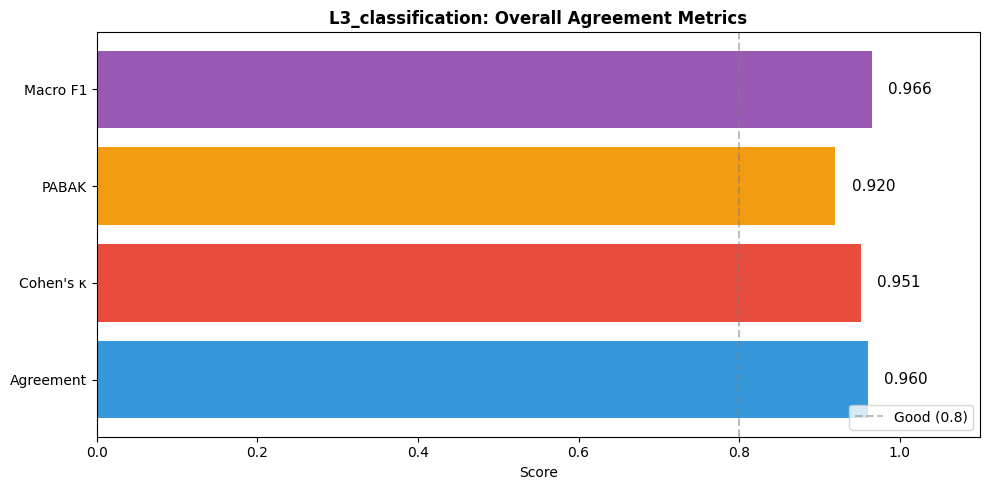


✓ Figure saved as: L3_classification_overall_metrics.png


In [48]:
# ============================================
# Overall Metrics Visualization
# ============================================

fig, ax = plt.subplots(figsize=(10, 5))

metrics = ['Agreement', "Cohen's κ", 'PABAK', 'Macro F1']
values = [pct/100, kappa, pabak, np.mean(f1_per_class)]
colors = ['#3498db', '#e74c3c', '#f39c12', '#9b59b6']

bars = ax.barh(metrics, values, color=colors)
ax.set_xlim(0, 1.1)
ax.set_xlabel('Score')
ax.set_title('L3_classification: Overall Agreement Metrics', fontsize=12, fontweight='bold')

# Add value labels
for bar, val in zip(bars, values):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=11)

# Add reference line at 0.8
ax.axvline(x=0.8, color='gray', linestyle='--', alpha=0.5, label='Good (0.8)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('L3_classification_overall_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as: L3_classification_overall_metrics.png")

In [49]:
# ============================================
# PRINT ALL METRICS SUMMARY
# ============================================
print("=" * 70)
print("L3_CLASSIFICATION: ALL METRICS SUMMARY")
print("=" * 70)

print(f"\n--- L3 Taxonomy ---")
print("Interactive MD:    Transitions, Frame Markers, Endophoric Markers, Evidentials, Code Glosses")
print("Interactional MD:  Hedges, Boosters, Attitude Markers, Self-Mentions, Engagement Markers")
print("Non-MD:            PROP (propositional)")

print(f"\n--- Overall Metrics ---")
print(f"Total items:            {total}")
print(f"Agreement:              {pct:.1f}%")
print(f"Cohen's κ:              {kappa:.3f}")
print(f"PABAK:                  {pabak:.3f}")

print(f"\n--- Per-Class Metrics ---")
print(f"{'Category':<25} {'N(Human)':<10} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 70)
for i, label in enumerate(labels_present):
    n_human = (human_col == label).sum()
    print(f"{label:<25} {n_human:<10} {prec_per_class[i]:<12.3f} {rec_per_class[i]:<12.3f} {f1_per_class[i]:<12.3f}")

print("-" * 70)
print(f"\n--- Macro Averages ---")
print(f"Macro Precision: {np.mean(prec_per_class):.3f}")
print(f"Macro Recall:    {np.mean(rec_per_class):.3f}")
print(f"Macro F1:        {np.mean(f1_per_class):.3f}")

# --- Error Analysis by Type ---
print(f"\n" + "=" * 70)
print("ERROR ANALYSIS: Disagreement Patterns")
print("=" * 70)

if len(disagree) > 0:
    # Create confusion pairs
    error_pairs = disagree.groupby(['L3_classification_human', 'L3_classification_llm']).size().reset_index(name='count')
    error_pairs = error_pairs.sort_values('count', ascending=False)

    print(f"\n{'Human Label':<25} {'LLM Label':<25} {'Count':<10}")
    print("-" * 60)
    for _, row in error_pairs.iterrows():
        print(f"{row['L3_classification_human']:<25} {row['L3_classification_llm']:<25} {row['count']:<10}")
else:
    print("No disagreements!")

L3_CLASSIFICATION: ALL METRICS SUMMARY

--- L3 Taxonomy ---
Interactive MD:    Transitions, Frame Markers, Endophoric Markers, Evidentials, Code Glosses
Interactional MD:  Hedges, Boosters, Attitude Markers, Self-Mentions, Engagement Markers
Non-MD:            PROP (propositional)

--- Overall Metrics ---
Total items:            50
Agreement:              96.0%
Cohen's κ:              0.951
PABAK:                  0.920

--- Per-Class Metrics ---
Category                  N(Human)   Precision    Recall       F1          
----------------------------------------------------------------------
Transition                7          0.778        1.000        0.875       
Frame Marker              17         1.000        1.000        1.000       
Endophoric Marker         5          1.000        1.000        1.000       
Evidential                4          1.000        1.000        1.000       
Hedge                     5          1.000        1.000        1.000       
Booster               